In [2]:
import polars as pl
# g_patent.tsv
df_patent = pl.read_csv(
    "g_patent.tsv",
    separator="\t",
    columns=["patent_id", "patent_date"],
    schema_overrides={"patent_id": pl.Utf8, "patent_date": pl.Utf8},
    ignore_errors=True
).with_columns([
    pl.col("patent_date").str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])

# g_cpc_current.tsv
df_cpc = pl.read_csv(
    "g_cpc_current.tsv",
    separator="\t",
    columns=["patent_id", "cpc_class"],
    schema_overrides={"patent_id": pl.Utf8, "cpc_class": pl.Utf8}
)

# g_assignee_disambiguated.tsv
df_assignee = pl.read_csv(
    "g_assignee_disambiguated.tsv",
    separator="\t",
    columns=["patent_id", "location_id"],
    schema_overrides={"patent_id": pl.Utf8, "location_id": pl.Utf8}
)

# g_location_disambiguated.tsv
df_location = pl.read_csv(
    "g_location_disambiguated.tsv",
    separator="\t",
    columns=["location_id", "disambig_country"],
    schema_overrides={"location_id": pl.Utf8, "disambig_country": pl.Utf8}
)
# g_cpc_title.tsv
df_cpc_title = pl.read_csv(
    "g_cpc_title.tsv",
    separator="\t",
    columns=["cpc_class", "cpc_class_title"],
    schema_overrides={"cpc_class": pl.Utf8, "cpc_class_title": pl.Utf8}
)




In [3]:
df_pa = df_cpc.join(df_assignee, on="patent_id", how="inner")


In [4]:
df_pal = df_pa.join(df_location, on="location_id", how="inner")

In [5]:
df_full = df_pal.join(df_patent, on="patent_id", how="inner")

In [6]:
# -------------------------------
# CÁLCULO DE RCA
# -------------------------------


df_full = df_full.with_columns([
    pl.col("patent_date").dt.year().alias("year")
])

# Conteo de patentes por país, clase, y año
df_counts = df_full.group_by(["disambig_country", "cpc_class", "year"]).agg(
    pl.len().alias("patents_country_class_year")
)

# Totales
df_total_country_year = df_counts.group_by(["disambig_country", "year"]).agg(
    pl.sum("patents_country_class_year").alias("total_country_year")
)

df_total_class_year = df_counts.group_by(["cpc_class", "year"]).agg(
    pl.sum("patents_country_class_year").alias("total_class_year")
)

df_total_year = df_counts.group_by("year").agg(
    pl.sum("patents_country_class_year").alias("total_global_year")
)

# RCA = (x_cr / x_r) / (x_c / x_total)
df_rca = (
    df_counts
    .join(df_total_country_year, on=["disambig_country", "year"], how="left")
    .join(df_total_class_year, on=["cpc_class", "year"], how="left")
    .join(df_total_year, on="year", how="left")
    .with_columns([
        pl.col("patents_country_class_year"),
        pl.col("total_country_year"),
        pl.col("total_class_year"),
        pl.col("total_global_year")
    ])
    .with_columns([
        (
            (pl.col("patents_country_class_year") / pl.col("total_country_year")) /
            (pl.col("total_class_year") / pl.col("total_global_year"))
        ).alias("rca")
    ])
)

# -------------------------------
# 4. Resultado
# -------------------------------

print(df_rca.head())


shape: (5, 8)
┌─────────────┬───────────┬──────┬─────────────┬─────────────┬─────────────┬────────────┬──────────┐
│ disambig_co ┆ cpc_class ┆ year ┆ patents_cou ┆ total_count ┆ total_class ┆ total_glob ┆ rca      │
│ untry       ┆ ---       ┆ ---  ┆ ntry_class_ ┆ ry_year     ┆ _year       ┆ al_year    ┆ ---      │
│ ---         ┆ str       ┆ i32  ┆ year        ┆ ---         ┆ ---         ┆ ---        ┆ f64      │
│ str         ┆           ┆      ┆ ---         ┆ u32         ┆ u32         ┆ u32        ┆          │
│             ┆           ┆      ┆ u32         ┆             ┆             ┆            ┆          │
╞═════════════╪═══════════╪══════╪═════════════╪═════════════╪═════════════╪════════════╪══════════╡
│ DE          ┆ B02       ┆ 1998 ┆ 41          ┆ 38456       ┆ 320         ┆ 703653     ┆ 2.344382 │
│ CH          ┆ H03       ┆ 1990 ┆ 10          ┆ 4358        ┆ 3539        ┆ 311502     ┆ 0.201973 │
│ GB          ┆ B32       ┆ 2020 ┆ 587         ┆ 52400       ┆ 53143       ┆ 

In [7]:
df_rca.select([
    pl.col(col).is_null().sum().alias(f"{col}_nulls")
    for col in df_rca.columns
])


disambig_country_nulls,cpc_class_nulls,year_nulls,patents_country_class_year_nulls,total_country_year_nulls,total_class_year_nulls,total_global_year_nulls,rca_nulls
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


In [8]:
df_rca_binaria = df_rca.with_columns([
    (pl.col("rca") > 1).cast(pl.Int8).alias("rca_binary")
])

In [12]:
df_chile_bin = df_rca_binaria.filter(pl.col("disambig_country") == "CL")

df_bin_pd = df_chile_bin.select(["year", "cpc_class", "rca_binary"]).to_pandas()
df_cpc_title = pl.read_csv(
    "g_cpc_title.tsv",
    separator="\t",
    columns=["cpc_class", "cpc_class_title"],
    schema_overrides={"cpc_class": pl.Utf8, "cpc_class_title": pl.Utf8}
).to_pandas()


In [13]:
df_bin_joined = df_bin_pd.merge(
    df_cpc_title.drop_duplicates(subset="cpc_class"),
    on="cpc_class", how="left"
)


In [25]:
df_bin_filtered = df_bin_joined[df_bin_joined["rca_binary"] == 1]

# Eliminar duplicados por clase
df_unique = df_bin_filtered.drop_duplicates(subset=["cpc_class", "cpc_class_title"])

# Exportar
df_unique.to_excel("rca_chile_unicos.xlsx", index=False)



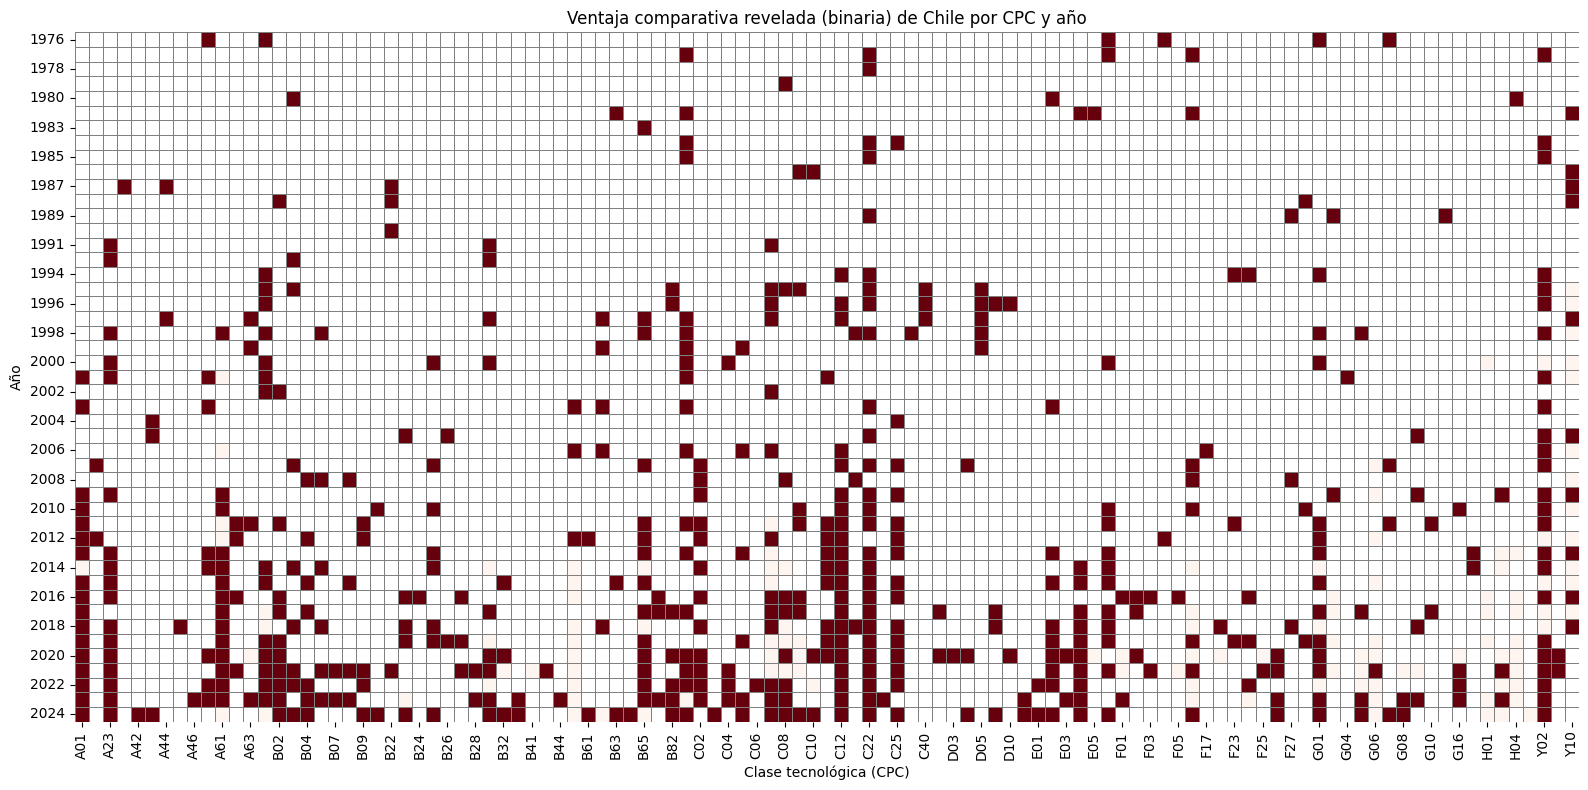

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar Chile y convertir a pandas
df_chile_bin = df_rca_binaria.filter(pl.col("disambig_country") == "CL")
df_bin_pd = df_chile_bin.select(["year", "cpc_class", "rca_binary"]).to_pandas()

# Pivot table
pivot_bin = df_bin_pd.pivot(index="year", columns="cpc_class", values="rca_binary")

# Heatmap binario (ventaja = rojo, no ventaja = gris claro)
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_bin, cmap="Reds", linewidths=0.5, linecolor='gray', cbar=False)
plt.title("Ventaja comparativa revelada (binaria) de Chile por CPC y año")
plt.xlabel("Clase tecnológica (CPC)")
plt.ylabel("Año")
plt.tight_layout()
plt.show()



In [27]:
df_chile_bin = df_rca_binaria.filter(pl.col("disambig_country") == "CL")

# Extract unique CPC classes where Chile has RCA = 1
unique_advantage_classes = (
    df_chile_bin
    .filter(pl.col("rca_binary") == 1)
    .select("cpc_class")
    .unique()
)

# Convert to pandas for viewing or export
unique_advantage_classes_pd = unique_advantage_classes.to_pandas()
print(unique_advantage_classes_pd)

    cpc_class
0         B23
1         B08
2         G08
3         A47
4         F03
..        ...
99        G07
100       B25
101       D21
102       G21
103       B01

[104 rows x 1 columns]


In [28]:
import pandas as pd

# 1. Filtrar RCA binaria de Chile (ventaja comparativa)
df_chile_secciones = df_rca_binaria.filter(
    (pl.col("disambig_country") == "CL") & (pl.col("rca_binary") == 1)
).with_columns([
    pl.col("cpc_class").str.slice(0, 1).alias("cpc_section")
])

# 2. Agrupar por sección CPC y contar cuántas veces Chile tuvo RCA > 1
df_resultado = df_chile_secciones.group_by("cpc_section").agg(
    pl.len().alias("veces_con_rca")
)

# 3. Convertir a pandas para enriquecer con nombres oficiales
df_resultado_pd = df_resultado.to_pandas()

# 4. Diccionario con nombres oficiales CPC
cpc_section_labels = {
    "A": "Human Necessities",
    "B": "Performing Operations; Transporting",
    "C": "Chemistry; Metallurgy",
    "D": "Textiles; Paper",
    "E": "Fixed Constructions",
    "F": "Mechanical Engineering; Lighting; Heating; Weapons; Blasting",
    "G": "Physics",
    "H": "Electricity",
    "Y": (
        "General Tagging of New Technological Developments; Cross-Sectional Technologies; XRACs and Digests"
    )
}

# 5. Agregar nombre oficial y ordenar
df_resultado_pd["nombre_seccion"] = df_resultado_pd["cpc_section"].map(cpc_section_labels)
df_resultado_pd = df_resultado_pd.sort_values("veces_con_rca", ascending=False).reset_index(drop=True)

print(df_resultado_pd)




  cpc_section  veces_con_rca  \
0           C            154   
1           B            140   
2           A             75   
3           G             41   
4           E             39   
5           F             38   
6           Y             36   
7           D             19   
8           H              4   

                                      nombre_seccion  
0                              Chemistry; Metallurgy  
1                Performing Operations; Transporting  
2                                  Human Necessities  
3                                            Physics  
4                                Fixed Constructions  
5  Mechanical Engineering; Lighting; Heating; Wea...  
6  General Tagging of New Technological Developme...  
7                                    Textiles; Paper  
8                                        Electricity  
